## map2loop: From geology layers to outputs to various 3D modelling programs- W Musgrove example (Geomodeller fix?)

This notebook reads in three layers from  local or remote sources:  geology polygons, orientation data and fault polylines; and calculates the topological relationships between the different features. Requires compiled cpp code from Vitaliy Ogarko

This all gets fed into successive tolopogical and geometric transfroms that end up feeding into geomodeller to make a 3D model 
<img src='../graphics/map_sm.png'>

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
import stat
import functools 
import operator  
import matplotlib
import networkx as nx
import rasterio
from shapely.geometry import Polygon
from map2loop import m2l_utils
from map2loop import m2l_topology
from map2loop import m2l_geometry
from map2loop import m2l_interpolation
from map2loop import m2l_export
%matplotlib inline

#newwd="C:\\Users\\00073294\Dropbox\\loop_minex\\map2model\\"
#os.chdir(newwd)
print("Current Working Directory " )

gdal_data = os.environ['GDAL_DATA']
print("***",gdal_data)
print('is dir: ' + str(os.path.isdir(gdal_data)))
gcs_csv = os.path.join(gdal_data, 'gcs.csv')
print('is file: ' + str(os.path.isfile(gcs_csv)))
st = os.stat(gcs_csv)
print('is readable: ' + str(bool(st.st_mode & stat.S_IRGRP)))
os.environ['PROJ_LIB']=r"C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj"
print(os.getenv('PROJ_LIB'))
print(os.getcwd())

Current Working Directory 
*** C:\Program Files\PostgreSQL\11\gdal-data
is dir: True
is file: True
is readable: True
C:\\Users\\00073294\\AppData\\Local\\Continuum\\anaconda3\\Lib\\site-packages\\pyproj\\proj_dir\\share\\proj
C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\notebooks


## Create bounding box based on inputs

In [2]:
test_data_name='test_data4'

test_data_path='../'+test_data_name+'/'

os.chdir(test_data_path)
%run -i "m2l_config.py"
#%run -i "m2l_config_remote.py"
print(os.getcwd())

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)


Default parameters loaded from ../test_data4/m2l_config.py:
#ROI

step_out=0.1   #padding arounf dtm to ensure reprojected dtm covers target area (in degrees)
inset=0      #unused??

minx=1449630  #region of interest coordinates in metre-based system (or non-degree system)
maxx=1522114
miny=7040497
maxy=7137538
model_top=1200
model_base=-8200

#PATHS

local_paths=False       #flag to use local or WFS source for data inputs (True = local)

test_data_path='../test_data4/'
m2m_cpp_path='../m2m_cpp/'

geology_file='hams2_geol.shp'   #input geology file (if local)
fault_file='GEOS_GEOLOGY_LINEARSTRUCTURE_500K_GSD.shp' #input fault file (if local)
structure_file='hams2_structure.shp' #input bedding orientation file (if local)
mindep_file='mindeps_2018.shp' #input mineral deposit file (if local)


#CRS

src_crs = {'init': 'EPSG:4326'}  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
dst_crs = {'init': 'EPSG:28350'} # coordinate system for data

#codes and labels thes

In [3]:

fold_decimate=2         

contact_decimate=5

use_interpolations=True       #use interpolated dips/contacts as additional constraints

use_fat=True                   #use fold axial trace orientation hints

pluton_form='domes'

fault_dip=-999

min_fault_length=5000

compute_etc=False

## First we test to see if we have access to the online data we need


In [4]:
loopwfs=m2l_utils.have_access("geo.waxi-gis.org")
hawaii=m2l_utils.have_access("pae-paha.pacioos.hawaii.edu")

if(not (loopwfs & hawaii)):
    local_paths=True
    net=False
    print('using local paths')
else:
    net=True

available: geo.waxi-gis.org
available: pae-paha.pacioos.hawaii.edu


## Optional WFS source
  
WFS brings in field names as lower case, so need to redefine codes too

In [5]:
if((not local_paths) and net):
    structure_file='http://geo.waxi-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=warox_wa_28350&bbox='+bbox2+'&srs=EPSG:28350'
    fault_file='http://geo.waxi-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=linear_500k&bbox='+bbox2+'&srs=EPSG:28350'
    geology_file='http://geo.waxi-gis.org/geoserver/loop/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=loop:geol_500k&bbox='+bbox2+'&srs=EPSG:28350'

    c_l= {
    #Orientations
      "d": "dip",                  #field that contains dip information
      "dd": "strike",             #field that contains dip direction information
      "sf": 'structypei',             #field that contains information on type of structure
      "bedding": 'BE',            #text to search for in field defined by sfcode to show that this is a bedding measurement
    #Stratigraphy
      "g": 'group_',               #field that contains coarser stratigraphic coding
      "c": 'code',                 #field that contains finer stratigraphic coding
      "ds": 'descriptn',           #field that contains information about lithology
      "u": 'unitname',             #field that contains alternate stratigraphic coding (not used??)
      "r1": 'rocktype1',           #field that contains  extra lithology information
      "r2": 'rocktype2',           #field that contains even more lithology information
      "sill": 'sill',              #text to search for in field defined by dscode to show that this is a sill
      "intrusive": 'intrusive',    #text to search for in field defined by dscode to show that this is an intrusion
      "volcanic": 'volcanic',      #text to search for in field defined by dscode to show that this is an intrusion
    #Mineral Deposits
      "msc": 'SITE_CODE',          #field that contains site code of deposit
      "msn": 'SHORT_NAME',         #field that contains short name of deposit
      "mst": 'SITE_TYPE_',         #field that contains site type of deposit
      "mtc": 'TARGET_COM',         #field that contains target commodity of deposit
      "mscm": 'SITE_COMMO',        #field that contains site commodity of deposit
      "mcom": 'COMMODITY_',        #field that contains commodity group of deposit
      "minf": 'Infrastructure',    #text to search for in field defined by mst code that shows site to ignore
    #Timing
      "min": 'min_age_ma',         #field that contains minimum age of unit defined by ccode
      "max": 'max_age_ma',         #field that contains maximum age of unit defined by ccode
    #faults and folds
      "f": 'feature',              #field that contains information on type of structure
      "fault": 'Fault',            #text to search for in field defined by fcode to show that this is a fault
      "fold": 'Fold axial trace',  #text to search for in field defined by fcode to show that this is a fold axial trace
      "n": 'name',                 #field that contains information on name of fault (not used??)
      "t": 'type',                 #field that contains information on type of fold
      "syn": 'syncline',           #text to search for in field defined by t to show that this is a syncline
    #ids
      "o": 'objectid',             #field that contains unique id of geometry object
      "gi": 'geopnt_id'            #field that contains unique id of structure point
    }

## Plot geology polygons and bounding box

http://geo.waxi-gis.org/geoserver/loop/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=loop:geol_500k&bbox=1449630,7040497,1522114,7137538&srs=EPSG:28350


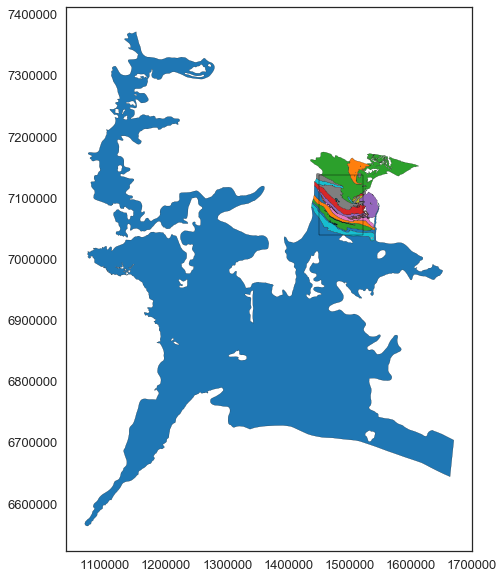

In [6]:
print(geology_file)
geology_ll = gpd.read_file(geology_file,bbox=bbox)

base=geology_ll.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
polygon.plot(ax=base, color='none',edgecolor='black')


## Save geology to file as WKT

In [7]:
sub_geol = geology_ll[['geometry', c_l['o'],c_l['c'],c_l['g'],c_l['u'],c_l['min'],c_l['max'],c_l['ds'],c_l['r1'],c_l['r2']]]
m2l_topology.save_geol_wkt(sub_geol,geology_file_csv, c_l)

50  polygons


## Save mineral deposits to file as WKT
This is not needed by map2loop to build 3D models, but is used by map2model to calculate mineral deposit/topology analyses.

20  points


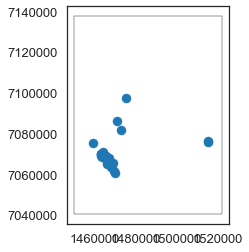

In [8]:
mindep = gpd.read_file(mindep_file,bbox=bbox)

sub_mindep = mindep[['geometry', c_l['msc'],c_l['msn'],c_l['mst'],c_l['mtc'],c_l['mscm'],c_l['mcom']]]
m2l_topology.save_mindep_wkt(sub_mindep,mindep_file_csv, c_l)

base=sub_mindep.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Read and save WAROX point data as WKT

http://geo.waxi-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=warox_wa_28350&bbox=1449630,7040497,1522114,7137538&srs=EPSG:28350
156  points


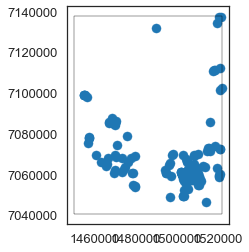

In [9]:
print(structure_file)

warox = gpd.read_file(structure_file,bbox=bbox)

sub_pts = warox[['geometry', c_l['gi'],c_l['d'],c_l['dd']]]

m2l_topology.save_structure_wkt(sub_pts,structure_file_csv,c_l)

base=sub_pts.plot()
polygon.plot(ax=base, color='none',edgecolor='black')


## Plot faults and bounding box

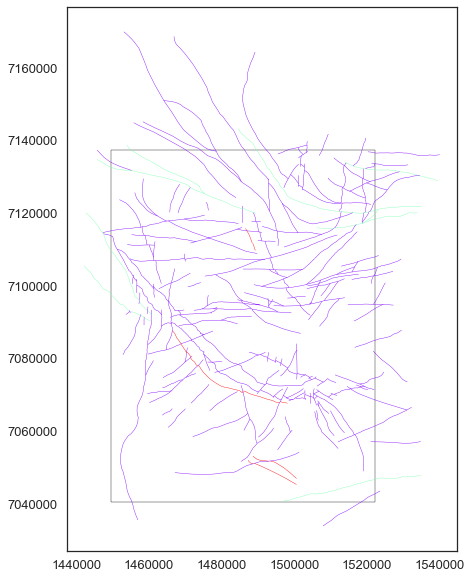

In [10]:
lines_ll=gpd.read_file(fault_file,bbox=bbox)

base2=lines_ll.plot(cmap='rainbow',column=c_l['f'],figsize=(10,10),linewidth=0.4)
polygon.plot(ax=base2, color='none',edgecolor='black')


## Save faults to file as WKT

In [11]:
sub_lines = lines_ll[['geometry', c_l['o'],c_l['f']]]
m2l_topology.save_faults_wkt(sub_lines,fault_file_csv,c_l)

294  polylines


## Create map2model input file

In [12]:
m2l_topology.save_Parfile(m2m_cpp_path,c_l,graph_path,geology_file_csv,fault_file_csv,structure_file_csv,minx,maxx,miny,maxy)


## Calculate topology

In [13]:
os.chdir(m2m_cpp_path)
print(os.getcwd())
%system map2model.exe Parfile

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\m2m_cpp


['Reading data from the file: Parfile',
 '--- COLUMN NAMES IN CSV DATA FILES: -------------------------------------------------------------',
 'OBJECT COORDINATES              =WKT',
 'FAULT: ID                       =objectid',
 'FAULT: FEATURE                  =feature',
 'POINT: ID                       =geopnt_id',
 'POINT: DIP                      =dip',
 'POINT: DIP DIR                  =strike',
 'POLYGON: ID                     =objectid',
 'POLYGON: LEVEL1 NAME            =unitname',
 'POLYGON: LEVEL2 NAME            =group_',
 'POLYGON: MIN AGE                =min_age_ma',
 'POLYGON: MAX AGE                =max_age_ma',
 'POLYGON: CODE                   =code',
 'POLYGON: DESCRIPTION            =descriptn',
 'POLYGON: ROCKTYPE1              =rocktype1',
 'POLYGON: ROCKTYPE2              =rocktype2',
 '--- SOME CONSTANTS: ----------------------------------------------------------------------------',
 'FAULT AXIAL FEATURE NAME        =Fold axial trace',
 'SILL UNIT DESCRIPTION 

## Simple network graph of the geology with legend

C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


0    'P_-WKg1-xo-a'
1    'P_-WK-g'
2    'P_-BUL-sk'
3    'P_-_lu-se'
4    'P_-PGs-fr'
5    'P_-PUg-xbb-s'
6    'P_-KRd-sg'
7    'CP-_pa-sepg'
8    'P_-CA-xbb-fr'
9    'P_-BU-xs-k'
10    'P_-KR-xs-b'
11    'P_-PU-frp'
12    'P_-WK-od'
13    'P_-MI-xbb-s'
14    'P_-PGw-xfr-sp'
15    'P_-WK-xo-f'
16    'P_-od'
17    'P_-PGe-xfr-sp'
18    'P_-PK-xfr-frv'
19    'P_-WKg1-og'
20    'P_-PU-xss-bb'
21    'P_-PUk-fr'


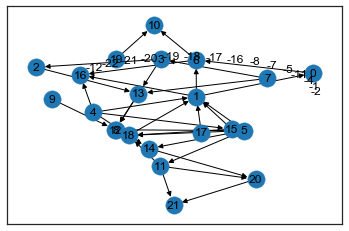

In [14]:
G=nx.read_gml(strat_graph_file,label='id')
selected_nodes = [n for n,v in G.nodes(data=True) if n >=0]
nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), arrows=True, nodelist=selected_nodes)

nlist=list(G.nodes.data('LabelGraphics'))
nlist.sort()
for no in nlist:
    if(no[0]>=0):
        elem=str(no[1]).replace("{'text':","").replace(", 'fontSize': 14}","")
        #second=elem.split(":").replace("'","")
        print(no[0]," ",elem)

## Detailed Topology via dot or gml format files
For a more detailed look we can open up the online version of <b>yEd</b> <a href="https://www.yworks.com/yed-live/" >https://www.yworks.com/yed-live/</a>  and load in the *.dot file that we will now create or dowload the <a href="https://www.yworks.com/products/yed/download">yEd program</a> and look at the *.gml files in the <b>output</b> directory

from networkx.drawing.nx_pydot import write_dot

import filer,gfiler

filepath=filer.gui_fname().decode('UTF-8')
write_dot(G,filepath)

http://localhost:8888/notebooks/Dropbox/1_Jupyter_notebooks/map2loop/notebooks/2.%20map2loop_after_topology.ipynb

## Process topography, stratigraphy, fold axial traces and faults

### Takes GML file produced by topology code, combines with geology polygons, structure points and dtm to create 3D model in gempy.<br><br>

Limitations:  no dykes, no sills. Sills require us to assign a unique surface to each instance of a sill (sill between units A and B needs to be different from sill of same age and strat codes as one found between E and F). Dykes via cokriging are really hard without just cookie cutting them in (but that is not our problem!). We are not checking for onlap relationships, which can perhaps been seen by having lots of units from one series adjacent to the youngest surface of the older series. Could also think about interpreting these as faults to introduce conceptual uncertainty. All mistakes belong to Mark Jessell, topology code that feeds this system by Vitaliy Ogarko.<br><br>

Geology layer needs to have some unique strat code or text, some group code or text to function<br>
Structure layer needs dip/dip direction<br>

<font color='red'>Currently mostly hardwired to GSWA 500K map so needs work...</font>


In [15]:
os.chdir('../map2loop')

print(os.getcwd())

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


In [16]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

sys.path.insert(0,"../..")
print(os.getcwd())


#print(os.getcwd())
#os.environ["PROJ_LIB"] = r"C:\Users\00073294\AppData\Local\Continuum\anaconda3\Lib\site-packages\pyproj\proj_dir\share\proj"


C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Next we define an area of interest and some other basic stuff

In [17]:
print(os.getcwd())
#test_data_path='../test_data3/'


#%run -i "../test_data3/m2l_config.py"

bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
lat_point_list = [miny, miny, maxy, maxy, maxy]
lon_point_list = [minx, maxx, maxx, minx, minx]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
bbox=(minx,miny,maxx,maxy)

step_out=0.045 #add (in degrees) so edge pixel from dtm reprojection are not found


#contact_decimate=5

C:\Users\00073294\Dropbox\1_Jupyter_notebooks\map2loop\map2loop


## Download and reproject the appropriate SRTM data
mj: Getting this from GA, but could also get from Hawaii

In [21]:
polygon_ll=polygon.to_crs(src_crs)

minlong=polygon_ll.total_bounds[0]-step_out
maxlong=polygon_ll.total_bounds[2]+step_out
minlat=polygon_ll.total_bounds[1]-step_out
maxlat=polygon_ll.total_bounds[3]+step_out

print(minlong,maxlong,minlat,maxlat)
if((not local_paths) and net):     
    m2l_utils.get_dtm(dtm_file, minlong,maxlong,minlat,maxlat)
    geom_rp=m2l_utils.reproject_dtm(dtm_file,dtm_reproj_file,src_crs,dst_crs)



126.38318924566974 127.25916547672362 -26.483484781754555 -25.481218592122303
dtm geotif saved as ../test_data4/dtm/dtm.tif
reprojected dtm geotif saved as ../test_data4/dtm/dtm_rp.tif


## Load stratigraphy graph and create list of series (aka groups)
mj: The choice of what constitutes basic unit and what a group of units is hard-wired at the moment, but could be altered to any pair. Not even sure we need two levels but it seemed like a good idea at the time. Note that this needs the arcgis plugin version of the topology code (for now) as it seperates the different sub graphs. Text outputs list alternate topologies for series and surfaces, which if confirmed by comapring max-min ages will be a nice source of uncertainty.

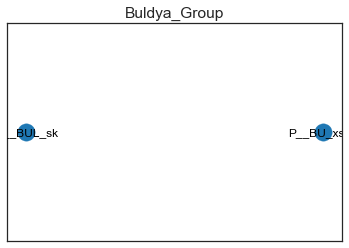

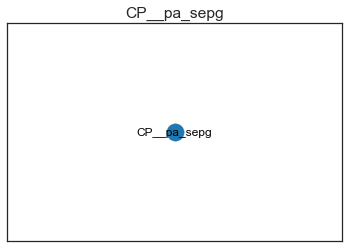

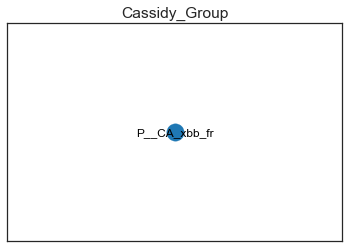

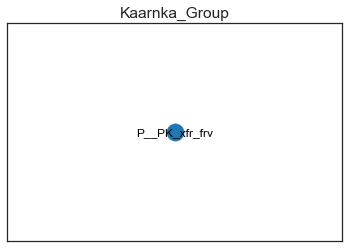

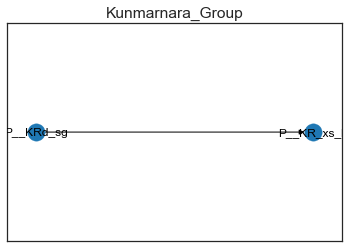

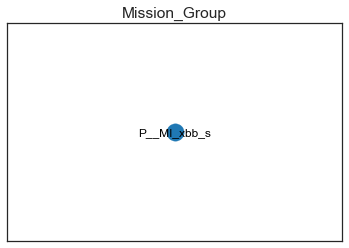

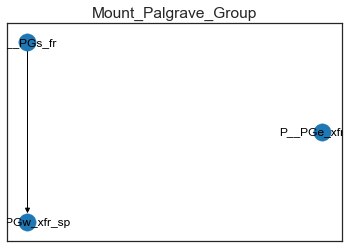

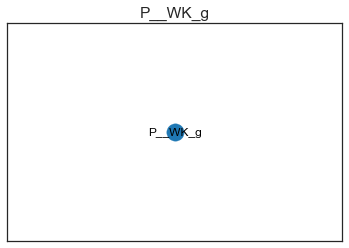

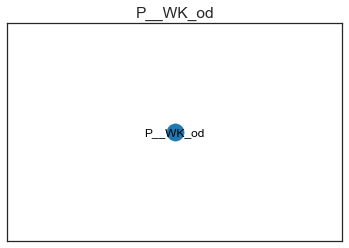

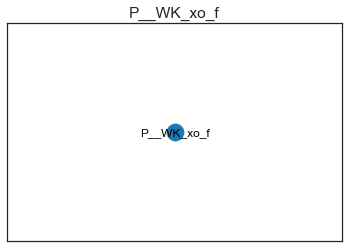

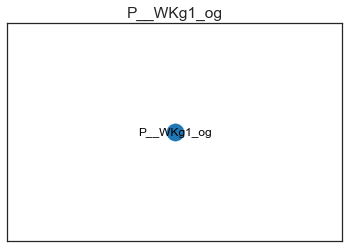

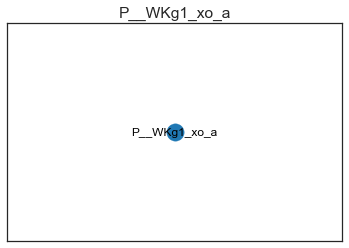

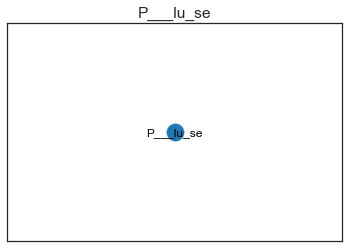

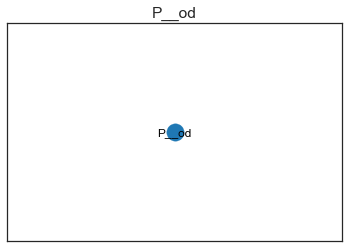

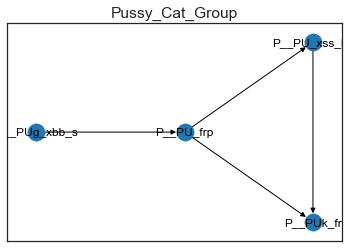

In [22]:
groups,glabels,G = m2l_topology.get_series(strat_graph_file,'id')
m2l_topology.save_units(G,tmp_path,glabels)

## Load geology & structure data
Currently loading from local files, but could load geology from WFS server at GSWA EXCEPT that the WFS online map has less fields that the zipped shapefiles. Go figure. We don't use fault layer at the moment (except for Vitaliy's topology code) but same logic applies in terms of where to get it from. Already have fault/strat relationships and once we have fault/fault relationships will start to include faults in models.

http://geo.waxi-gis.org/geoserver/loop/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=linear_500k&bbox=1449630,7040497,1522114,7137538&srs=EPSG:28350


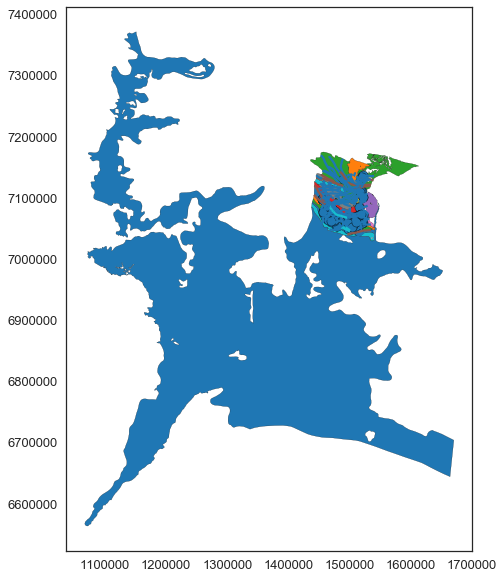

In [23]:
# Extract point data from structure & geology layers for modelling
##First we readin the structure and map from shapefiles, or wherever...

bbox=(minx,miny,maxx,maxy)
geology = gpd.read_file(geology_file,bbox=bbox)


structure = gpd.read_file(structure_file,bbox=bbox)
structure.crs=dst_crs
print(fault_file)
faults = gpd.read_file(fault_file,bbox=bbox)
faults.crs=dst_crs
#display(faults)
sub_pts = structure[['geometry',c_l['d'],c_l['dd'],c_l['sf']]] 

base=geology.plot(column=c_l['c'],figsize=(10,10),edgecolor='#000000',linewidth=0.2)
sub_pts.plot(ax=base,edgecolor='black')
faults.plot(ax=base, column=c_l['f'],edgecolor='black')

## Clip geology, faults, structures and map geology to structures

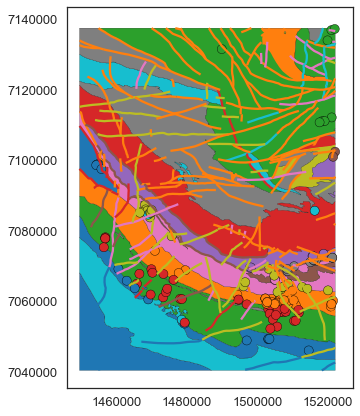

In [24]:
geology = m2l_utils.explode(geology)
geology.crs = dst_crs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
structure_code = gpd.sjoin(sub_pts, geology, how="left", op="within")

y_point_list = [miny, miny, maxy, maxy, miny]
x_point_list = [minx, maxx, maxx, minx, minx]

bbox_geom = Polygon(zip(x_point_list, y_point_list))

polygo = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom]) 
#display(polygo.geometry)
is_bed=structure_code[c_l['sf']].str.contains(c_l['bedding'], regex=False) 
    
all_beds = structure_code[is_bed]
#display(sfcode)
all_folds=faults[faults[c_l['f']].str.contains(c_l['fold'])]
folds_clip=m2l_utils.clip_shp(all_folds,polygo)
folds_clip.to_file(tmp_path+'folds_clip.shp')


all_faults=faults[faults[c_l['f']].str.contains(c_l['fault'])]



#display(structure_code)
geol_clip=m2l_utils.clip_shp(geology, polygo)
faults_clip=m2l_utils.clip_shp(all_faults,polygo)
#display(faults_clip)
structure_clip = m2l_utils.clip_shp(all_beds, polygo)

base = geol_clip.plot(column=c_l['c'],figsize=(7,7),edgecolor='#000000',linewidth=0.2)
faults_clip.plot(ax=base, column=c_l['t'],edgecolor='black')
structure_clip.plot(ax=base, column=c_l['c'],edgecolor='black')

In [25]:
if(c_l['dd']=='strike'):
    structure_clip['azimuth2'] = structure_clip.apply(lambda row: row[c_l['dd']]+90.0, axis = 1)
    c_l['dd']='azimuth2'
    display(structure_clip)
    
geol_clip.to_file(tmp_path+'geol_clip.shp')
faults_clip.to_file(tmp_path+'faults_clip.shp')
structure_clip.to_file(tmp_path+'structure_clip.shp')

,geometry,dip,strike,structypei,index_right,gml_id,objectid,lithstrtno,code,unitname,gswastatus,rank,descriptn,parentcode,parentname,rocktype1,lithname1,qualifier1,qualifier2,mixedrock,rocktype2,lithname2,mixedqual1,mixedqual2,wastraunit,supersuite,suite,supergroup,group_,subgroup,formation,member,bed,state,watectunit,ssuite_tec,suite_tec,craton,superterra,craton_ter,domain_,greenstone,superbasin,basin,subbasin,subbasin_e,orogen,province,prov_tzone,tect_subdi,orog_for,orog_forsu,in_outlier,events,agefrom,ageto,max_age_ma,maxuncerty,min_age_ma,minuncerty,max_age_da,min_age_da,extract_da,shape_leng,shape_area,azimuth2
0,POINT (1455038.14551071 7098989.72942553),50,125,BEIN,10,geol_500k.17723,17725,785,P_-BU-xs-k,Buldya Group,Formal,Group,"Undivided sedimentary rocks; sandstone, siltst...",P_N-xs-k-CNS,"Sedimentary rocks, Centralian Superbasin Super...",sedimentary siliciclastic,None,None,None,Mixed,sedimentary carbonate,None,None,None,None,None,None,None,Buldya Group,None,None,None,None,Western Australia,Neoproterozoic basins,None,None,None,None,None,None,None,Centralian Superbasin,Officer Basin (Phase 1),None,None,None,None,None,None,None,None,None,Officer Basin Cenozoic diapirism (66 - 0.01 Ma...,Tonian,Tonian,1000,None,720,None,Inferred,Inferred,2016-06-30,0.705787,0.016324,215.0
1,POINT (1494371.81516377 7061975.83902729),37,90,BEIN,9,geol_500k.14803,14805,788,P_-CA-xbb-fr,Cassidy Group,Formal,Group,Massive to vesicular and amygdaloidal basalt a...,P_-BE-xs-f,Bentley Supergroup,igneous mafic volcanic,basalt,None,None,Mixed,igneous felsic volcanic,rhyolite,None,None,None,None,None,Bentley Supergroup,Cassidy Group,None,None,None,None,Western Australia,None,None,None,None,None,None,None,None,None,Bentley Basin,None,None,Paterson Orogen,None,None,None,None,None,None,Alice Springs Orogeny (450 - 295 Ma); Peterman...,Mesoproterozoic,Mesoproterozoic,1077,None,1047,None,Inferred,Inferred,2016-06-30,2.575704,0.052891,180.0
2,POINT (1506696.07646338 7063459.07241664),85,80,BEIN,5,geol_500k.17530,17532,1644,P_-PUg-xbb-s,Glyde Formation,Formal,Formation,"Typically vesicular and amygdaloidal basalt, a...",P_-PU-xbb-fr,Pussy Cat Group,igneous mafic volcanic,basalt,None,None,Mixed,sedimentary siliciclastic,None,None,None,None,None,None,Bentley Supergroup,Pussy Cat Group,None,Glyde Formation,None,None,Western Australia,None,None,None,None,None,None,None,None,None,Bentley Basin,None,None,Paterson Orogen,None,None,None,None,None,None,Alice Springs Orogeny (450 - 295 Ma); Peterman...,Mesoproterozoic,Mesoproterozoic,1077,None,1047,None,Inferred,Inferred,2016-06-30,3.395201,0.042298,170.0
3,POINT (1505401.53958044 7059775.47354043),40,84,BEIN,9,geol_500k.14803,14805,788,P_-CA-xbb-fr,Cassidy Group,Formal,Group,Massive to vesicular and amygdaloidal basalt a...,P_-BE-xs-f,Bentley Supergroup,igneous mafic volcanic,basalt,None,None,Mixed,igneous felsic volcanic,rhyolite,None,None,None,None,None,Bentley Supergroup,Cassidy Group,None,None,None,None,Western Australia,None,None,None,None,None,None,None,None,None,Bentley Basin,None,None,Paterson Orogen,None,None,None,None,None,None,Alice Springs Orogeny (450 - 295 Ma); Peterman...,Mesoproterozoic,Mesoproterozoic,1077,None,1047,None,Inferred,Inferred,2016-06-30,2.575704,0.052891,174.0
4,POINT (1508319.26358343 7059841.64465545),23,85,BEIN,9,geol_500k.14803,14805,788,P_-CA-xbb-fr,Cassidy Group,Formal,Group,Massive to vesicular and amygdaloidal basalt a...,P_-BE-xs-f,Bentley Supergroup,igneous mafic volcanic,basalt,None,None,Mixed,igneous felsic volcanic,rhyolite,None,None,None,None,None,Bentley Supergroup,Cassidy Group,None,None,None,None,Western Australia,None,None,None,None,None,None,None,None,None,Bentley Basin,None,None,Paterson Orogen,None,None,None,None,None,None,Alice Springs Orogeny (450 - 295 Ma); Peterman...,Mesoproterozoic,Mesoproterozoic,1077,None,1047,None,Inferred,Inferred,2016-06-30,2.575704,0.052891,175.0
5,POINT (1496109.39294412 7064311.75594656),45,98,BEIN,5,geol_500k.17530,17532,1644,P_-

,index,min,max,ave
group_,,,,
CP__pa_sepg,0,290.1,323.2,306.65
P___lu_se,1,635.0,720.0,677.50
Buldya_Group,2,720.0,1000.0,860.00
Mission_Group,3,1040.0,1057.0,1048.50
Cassidy_Group,4,1047.0,1077.0,1062.00
Pussy_Cat_Group,5,1047.0,1077.0,1062.00
Mount_Palgrave_Group,6,1047.0,1077.0,1062.00
P__WK_xo_f,7,1040.0,1084.0,1062.00
Kaarnka_Group,8,1047.0,1077.0,1062.00


[]

group choices: 1681680


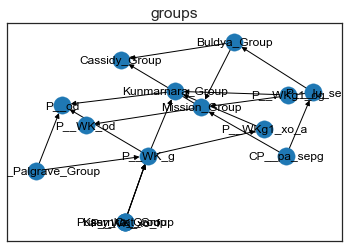

In [26]:
m2l_topology.save_group(G,tmp_path,glabels,geol_clip,c_l)

## Export orientation data in csv  format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. To calculate polarity <font color='red'>(WHICH WE DON'T DO YET)</font> we can calculate the dot product of the dip direction of a bedding plane and the vector to that points nearest basal contact node, if  abs(acos(dot product))>90  then right way up :

<img src='../graphics/polarity.png'>

Added code to not save intrusion orientation data as they won't have associated surfaces if sill...

In [27]:
display(structure_clip)

,geometry,dip,strike,structypei,index_right,gml_id,objectid,lithstrtno,code,unitname,gswastatus,rank,descriptn,parentcode,parentname,rocktype1,lithname1,qualifier1,qualifier2,mixedrock,rocktype2,lithname2,mixedqual1,mixedqual2,wastraunit,supersuite,suite,supergroup,group_,subgroup,formation,member,bed,state,watectunit,ssuite_tec,suite_tec,craton,superterra,craton_ter,domain_,greenstone,superbasin,basin,subbasin,subbasin_e,orogen,province,prov_tzone,tect_subdi,orog_for,orog_forsu,in_outlier,events,agefrom,ageto,max_age_ma,maxuncerty,min_age_ma,minuncerty,max_age_da,min_age_da,extract_da,shape_leng,shape_area,azimuth2
0,POINT (1455038.14551071 7098989.72942553),50,125,BEIN,10,geol_500k.17723,17725,785,P_-BU-xs-k,Buldya Group,Formal,Group,"Undivided sedimentary rocks; sandstone, siltst...",P_N-xs-k-CNS,"Sedimentary rocks, Centralian Superbasin Super...",sedimentary siliciclastic,None,None,None,Mixed,sedimentary carbonate,None,None,None,None,None,None,None,Buldya Group,None,None,None,None,Western Australia,Neoproterozoic basins,None,None,None,None,None,None,None,Centralian Superbasin,Officer Basin (Phase 1),None,None,None,None,None,None,None,None,None,Officer Basin Cenozoic diapirism (66 - 0.01 Ma...,Tonian,Tonian,1000,None,720,None,Inferred,Inferred,2016-06-30,0.705787,0.016324,215.0
1,POINT (1494371.81516377 7061975.83902729),37,90,BEIN,9,geol_500k.14803,14805,788,P_-CA-xbb-fr,Cassidy Group,Formal,Group,Massive to vesicular and amygdaloidal basalt a...,P_-BE-xs-f,Bentley Supergroup,igneous mafic volcanic,basalt,None,None,Mixed,igneous felsic volcanic,rhyolite,None,None,None,None,None,Bentley Supergroup,Cassidy Group,None,None,None,None,Western Australia,None,None,None,None,None,None,None,None,None,Bentley Basin,None,None,Paterson Orogen,None,None,None,None,None,None,Alice Springs Orogeny (450 - 295 Ma); Peterman...,Mesoproterozoic,Mesoproterozoic,1077,None,1047,None,Inferred,Inferred,2016-06-30,2.575704,0.052891,180.0
2,POINT (1506696.07646338 7063459.07241664),85,80,BEIN,5,geol_500k.17530,17532,1644,P_-PUg-xbb-s,Glyde Formation,Formal,Formation,"Typically vesicular and amygdaloidal basalt, a...",P_-PU-xbb-fr,Pussy Cat Group,igneous mafic volcanic,basalt,None,None,Mixed,sedimentary siliciclastic,None,None,None,None,None,None,Bentley Supergroup,Pussy Cat Group,None,Glyde Formation,None,None,Western Australia,None,None,None,None,None,None,None,None,None,Bentley Basin,None,None,Paterson Orogen,None,None,None,None,None,None,Alice Springs Orogeny (450 - 295 Ma); Peterman...,Mesoproterozoic,Mesoproterozoic,1077,None,1047,None,Inferred,Inferred,2016-06-30,3.395201,0.042298,170.0
3,POINT (1505401.53958044 7059775.47354043),40,84,BEIN,9,geol_500k.14803,14805,788,P_-CA-xbb-fr,Cassidy Group,Formal,Group,Massive to vesicular and amygdaloidal basalt a...,P_-BE-xs-f,Bentley Supergroup,igneous mafic volcanic,basalt,None,None,Mixed,igneous felsic volcanic,rhyolite,None,None,None,None,None,Bentley Supergroup,Cassidy Group,None,None,None,None,Western Australia,None,None,None,None,None,None,None,None,None,Bentley Basin,None,None,Paterson Orogen,None,None,None,None,None,None,Alice Springs Orogeny (450 - 295 Ma); Peterman...,Mesoproterozoic,Mesoproterozoic,1077,None,1047,None,Inferred,Inferred,2016-06-30,2.575704,0.052891,174.0
4,POINT (1508319.26358343 7059841.64465545),23,85,BEIN,9,geol_500k.14803,14805,788,P_-CA-xbb-fr,Cassidy Group,Formal,Group,Massive to vesicular and amygdaloidal basalt a...,P_-BE-xs-f,Bentley Supergroup,igneous mafic volcanic,basalt,None,None,Mixed,igneous felsic volcanic,rhyolite,None,None,None,None,None,Bentley Supergroup,Cassidy Group,None,None,None,None,Western Australia,None,None,None,None,None,None,None,None,None,Bentley Basin,None,None,Paterson Orogen,None,None,None,None,None,None,Alice Springs Orogeny (450 - 295 Ma); Peterman...,Mesoproterozoic,Mesoproterozoic,1077,None,1047,None,Inferred,Inferred,2016-06-30,2.575704,0.052891,175.0
5,POINT (1496109.39294412 7064311.75594656),45,98,BEIN,5,geol_500k.17530,17532,1644,P_-

In [28]:
dtm = rasterio.open(dtm_reproj_file)
m2l_geometry.save_orientations(structure_clip,output_path,c_l,orientation_decimate,dtm)


156 orientations saved to ../test_data4/output/orientations.csv


## Find those series that don't have any orientation or contact point data  then create arbitrary point for series with no orientation data
Not sure if gempy needs this but geomodeller does. Currently just gives a point dipping 45 degrees to North, but could use dip direction normal to basal surface)

In [29]:
m2l_geometry.create_orientations( tmp_path, output_path, dtm,geol_clip,structure_clip,c_l)

extra orientations saved as ../test_data4/output//empty_series_orientations.csv


## Export contact information subset of each polygon to gempy format
mj: Orientation data needs calculated height as file does not provide it, taken from SRTM data already downloaded. Need to reduce number of points whilst retaining useful info (Ranee's job!)'
To calculate which are the basal units contact for a polygon find the polygons which are older than the selected polygon, in the example below the central polygon has relative age 23 so its basal contact is with the polygons whose ages are 26 & 28. If there are no older units for a polygon it has no basal content. We keep every nth node based on the decimate term (simple count along polyline). gempy seems to need at least two points per surface, so we always take the first two points.


<img src='../graphics/base.png'>

In [30]:
ls_dict,ls_dict_decimate=m2l_geometry.save_basal_contacts(tmp_path,dtm,geol_clip,contact_decimate,c_l,intrusion_mode)

basal contacts saved allpts= 5269 deci_pts= 1168
saved as ../test_data4/tmp/all_contacts.csv and ../test_data4/tmp/contacts.csv


## Remove all basal contacts that are defined by faults and save to shapefile (no decimation)

In [31]:
display(ls_dict)

{0: {'id': 0,
  'code': 'CP__pa_sepg',
  'group_': 'CP__pa_sepg',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x163193dcf60>},
 1: {'id': 1,
  'code': 'P__BU_xs_k',
  'group_': 'Buldya_Group',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x163193dcba8>},
 2: {'id': 2,
  'code': 'P__BU_xs_k',
  'group_': 'Buldya_Group',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x163193dc198>},
 3: {'id': 3,
  'code': 'P__BUL_sk',
  'group_': 'Buldya_Group',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x163193e4ba8>},
 4: {'id': 4,
  'code': 'P__PU_frp',
  'group_': 'Pussy_Cat_Group',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x1631cbeb978>},
 5: {'id': 5,
  'code': 'P__WK_g',
  'group_': 'P__WK_g',
  'geometry': <shapely.geometry.multilinestring.MultiLineString at 0x1631941d668>},
 6: {'id': 6,
  'code': 'P__WK_g',
  'group_': 'P__WK_g',
  'geometry': <shapely.geometry.multilinestring.M

In [32]:
m2l_geometry.save_basal_no_faults(tmp_path+'basal_contacts.shp',tmp_path+'faults_clip.shp',ls_dict,10,c_l,dst_crs)

basal contacts without faults saved as ../test_data4/tmp/basal_contacts.shp


## Remove faults from decimated basal contacts as save as csv file

In [33]:
contacts=gpd.read_file(tmp_path+'basal_contacts.shp')

m2l_geometry.save_basal_contacts_csv(contacts,output_path,dtm,contact_decimate,c_l)

#m2l_geometry.save_contacts_with_faults_removed(tmp_path+'faults_clip.shp',output_path,10,ls_dict,ls_dict_decimate,c_l,dst_crs,dtm)

decimated contacts saved as ../test_data4/output/contacts4.csv


## Process fault geometry
Save Faults as decimated points and representative orientation  
Then, for each  fault string:
- incementally advance along polyline every at each inter-node (no point in doing more?)
- find local stratigraphy 10m to left and right of fault
  
Once full fault has been traversed:
- Find list of contacts left 
- Find equivalent contacts on right
- use interpolated orientations to estimate minimum true offset assuming vertical displacement and store 
- if no equivalent found, flag as domain fault and find min strat offset for contact, use cumulative minimum thickness estimate and store with flag (not implemented)
- estimate median & sd of minimum fault offset and store with flag (not implemented)

Local Orientations
Since much of the code is the same, we benefit by calculating local orientation data either side of fault so that geomodeller/gempy have satisfied fault compartment orientation data## Save fault as contact info and and orientation info make vertical (for the moment)

fault orientations saved as ../test_data4/output/fault_orientations.csv
fault positions saved as ../test_data4/output/faults.csv
fault dimensions saved as ../test_data4/output/fault_dimensions.csv


C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')
C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\interpolate\rbf.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=6.69405e-36): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


orientations interpolated as dip dip direction ../test_data4/tmp/f_interpolation_scipy_rbf.csv
orientations interpolated as l,m,n dir cos ../test_data4/tmp/f_interpolation_l.csv etc.
orientations interpolated as dip dip direction ../test_data4/tmp/ex_f_interpolation_scipy_rbf.csv
orientations interpolated as l,m,n dir cos ../test_data4/tmp/ex_f_interpolation_l.csv etc.


C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\interpolate\rbf.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=9.02339e-29): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


contacts interpolated as strike ../test_data4/tmp/f_interpolation_contacts_scipy_rbf.csv
contacts interpolated as l,m dir cos ../test_data4/tmp/f_interpolation_contacts_l.csv etc.


C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\interpolate\rbf.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=3.71723e-28): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


contacts interpolated as strike ../test_data4/tmp/ex_f_interpolation_contacts_scipy_rbf.csv
contacts interpolated as l,m dir cos ../test_data4/tmp/ex_f_interpolation_contacts_l.csv etc.
{'init': 'EPSG:28350'} None
contacts and orientations interpolated as dip dip direction ../test_data4/tmp/f_combo_full.csv
{'init': 'EPSG:28350'} None
contacts and orientations interpolated as dip dip direction ../test_data4/tmp/ex_f_combo_full.csv


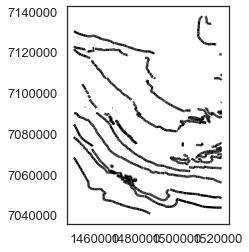

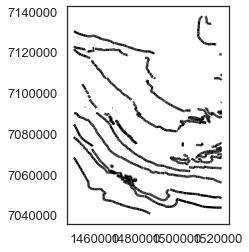

In [34]:
m2l_geometry.save_faults(tmp_path+'faults_clip.shp',output_path,dtm,c_l,fault_decimate,min_fault_length,fault_dip)

use_gcode=('Pussy Cat Group', 'Kaarnka Group', 'Mount Palgrave Group', 'Kunmarnara Group', 'Buldya Group', 'Mission Group', 'Cassidy Group' ) 
use_gcode2=('Pussy_Cat_Group', 'Kaarnka_Group', 'Mount_Palgrave_Group', 'Kunmarnara_Group', 'Buldya_Group', 'Mission_Group', 'Cassidy_Group' ) 

m2l_interpolation.process_fault_throw_and_near_orientations(tmp_path,output_path,dtm_reproj_file,c_l,use_gcode,use_gcode2,dst_crs,bbox,scheme)



## Process plutons

For each instruve but not sill polygon, find older neighbours and store decimated contact points. Also store dipping contact orientations (user defined, just because) with four possible sub-surface configurations:

<b>saucers: \\_+++_/ <br>
batholiths: +++/__ __ _\\+++  <br> 
domes: /‾+++‾\\ <br>
pendants: +++\\_  _/+++ <br>
</b>
  
Saves out orientations and contact points, as well as updated group level stratigraphic column.<br>


In [35]:
bbox=(minx,miny,maxx,maxy)

pluton_dip=str(pluton_dip)

dist_buffer=10
dtm = rasterio.open(dtm_reproj_file)
m2l_geometry.process_plutons(tmp_path,output_path,geol_clip,local_paths,dtm,pluton_form,pluton_dip,contact_decimate,c_l)


0 P__WKg1_og
1 P__WK_xo_f
2 Pussy_Cat_Group
3 Kaarnka_Group
4 Mount_Palgrave_Group
5 P__WK_g
6 P__WKg1_xo_a
7 Kunmarnara_Group
8 P__od
9 CP__pa_sepg
10 P___lu_se
11 Buldya_Group
12 Mission_Group
13 Cassidy_Group
14 P__WK_od
pluton contacts and orientations saved as:
../test_data4/output/ign_contacts.csv
../test_data4/output/ign_orientations_domes.csv


## Interpolates a regular grid of orientations from an  shapefile of arbitrarily-located points and saves out four csv files of l,m & n direction cosines and dip dip direction data

Can choose between various RBF and IDW options   
  
The purpose of these interpolations and associated code is to help in three cases:
- Providing estimated dips and contacts in fault-bounded domains where no structural data are available
- Needed to estimate true thickness of formations
- Possibly useful for poulating parts of maps where little structural data is available

In [36]:
use_gcode=('Pussy Cat Group', 'Kaarnka Group', 'Mount Palgrave Group', 'Kunmarnara Group', 'Buldya Group', 'Mission Group', 'Cassidy Group' ) 
structure_file=tmp_path+'structure_clip.shp'
bbox=(minx+inset,miny+inset,maxx-inset,maxy-inset)

In [37]:
print(c_l['g'])
print(use_gcode)

group_
('Pussy Cat Group', 'Kaarnka Group', 'Mount Palgrave Group', 'Kunmarnara Group', 'Buldya Group', 'Mission Group', 'Cassidy Group')


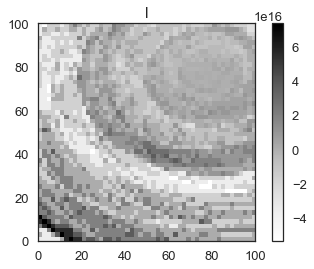

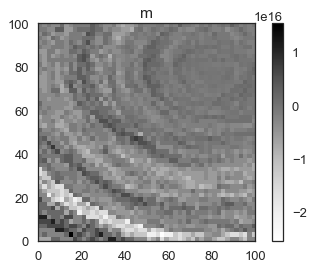

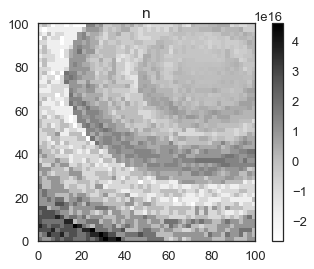

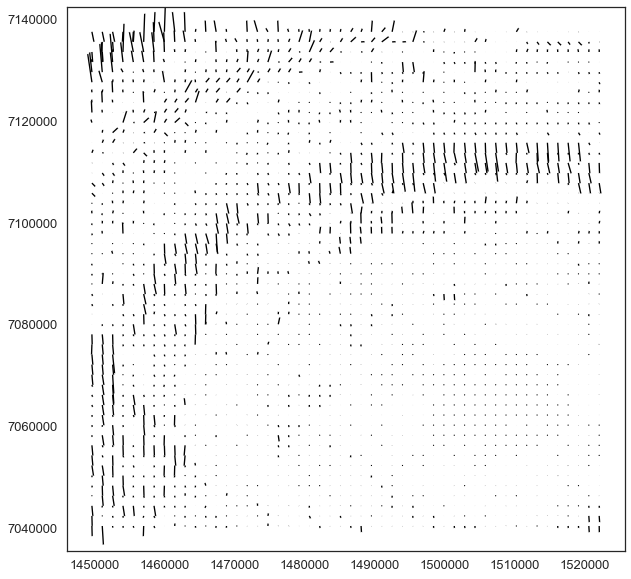

orientations interpolated as dip dip direction ../test_data4/tmp/interpolation_scipy_rbf.csv
orientations interpolated as l,m,n dir cos ../test_data4/tmp/interpolation_l.csv etc.


In [38]:
m2l_interpolation.interpolate_orientations(structure_file,tmp_path,bbox,c_l,use_gcode,scheme,gridx,gridy,False)

## Interpolates a regular grid from a shapefile of from contacts and saves out three csv files of l & m direction cosines and strike data

Can choose between various RBF and IDW options  

<font face color='red'>Best with basal contacts only, using Notebook #1 as this avoids intrusive  and fault contacts being considered</font>

In [39]:
geology_file=tmp_path+'basal_contacts.shp'

dtm = rasterio.open(dtm_reproj_file)
use_gcode=('Pussy_Cat_Group', 'Kaarnka_Group', 'Mount_Palgrave_Group', 'Kunmarnara_Group', 'Buldya_Group', 'Mission_Group', 'Cassidy_Group' ) ################# MOVE UP   #########################


46
2113 points saved to ../test_data4/tmp/raw_contacts.csv


C:\Users\00073294\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\interpolate\rbf.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=7.80574e-28): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


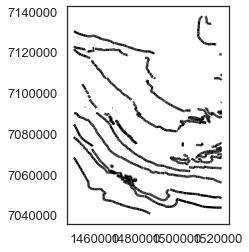

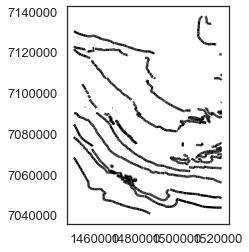

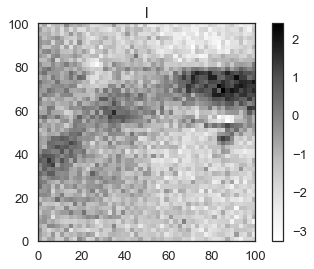

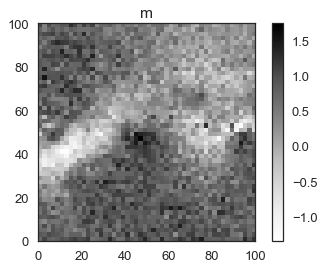

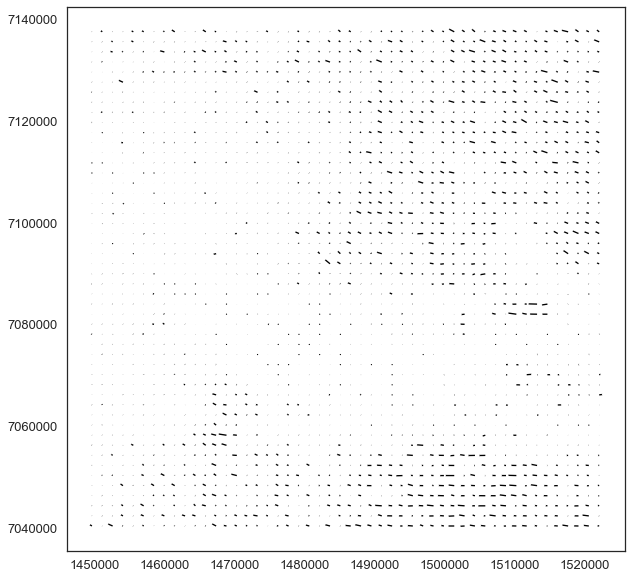

contacts interpolated as strike ../test_data4/tmp/interpolation_contacts_scipy_rbf.csv
contacts interpolated as l,m dir cos ../test_data4/tmp/interpolation_contacts_l.csv etc.


In [40]:
contact_decimate=2
null_scheme='null'

m2l_interpolation.save_contact_vectors(geology_file,tmp_path,dtm,bbox,c_l,null_scheme,contact_decimate)

m2l_interpolation.interpolate_contacts(geology_file,tmp_path,dtm,bbox,c_l,use_gcode,scheme,gridx,gridy,False)


## Combines rbf of contact orientations with rbf of dip/dipdir measurements

Uses normalised direction cosines **(l,m,n)**:  
- **l,m** from RBF of basal contact orientations  
- **signs of l & m** from misorientation with RBF of orientation data and  
- **n** from RBF of orientation data  
  
May be useful for adding data where no orientations are available (e.g. in fault bounded domains) and for calculating true thickness of layers. Assumes a 2D plane of data, but if 3D RBF was calulated and projected contact info was used it should apply with topography too. 

In [41]:
geology_file=tmp_path+'geol_clip.shp'
combo_file=tmp_path+'combo.csv'

lc=np.loadtxt(tmp_path+'interpolation_contacts_l.csv',skiprows =1,delimiter =',',dtype=float)
mc=np.loadtxt(tmp_path+'interpolation_contacts_m.csv',skiprows =1,delimiter =',',dtype=float)
lo=np.loadtxt(tmp_path+'interpolation_l.csv',skiprows =1,delimiter =',',dtype=float)
mo=np.loadtxt(tmp_path+'interpolation_m.csv',skiprows =1,delimiter =',',dtype=float)
no=np.loadtxt(tmp_path+'interpolation_n.csv',skiprows =1,delimiter =',',dtype=float)
xy=np.loadtxt(tmp_path+'interpolation_'+scheme+'.csv',skiprows =1,delimiter =',',dtype=float)

In [42]:
m2l_interpolation.join_contacts_and_orientations(combo_file,geology_file,tmp_path,dtm_reproj_file,c_l,lo,mo,no,lc,mc,xy,dst_crs,bbox,False)


{'init': 'EPSG:28350'} None
contacts and orientations interpolated as dip dip direction ../test_data4/tmp/combo_full.csv


## Estimate formation thickness and normalised formation thickness

In [43]:
buffer =5000
max_thickness_allowed=10000

m2l_geometry.calc_thickness(tmp_path,output_path,buffer,max_thickness_allowed,c_l)

m2l_geometry.normalise_thickness(output_path)

561 thickness estimates saved as ../test_data4/output/formation_thicknesses.csv
P__BUL_sk 1733.0 964.1271148488613
P__PGs_fr 2119.0 731.7185873906751
P__PU_frp 2269.5 904.9347625408302
P__PU_xss_bb 929.0 469.6387374421892


## Creates fold axial trace points

In [44]:
m2l_geometry.save_fold_axial_traces(tmp_path+'folds_clip.shp',output_path,dtm,c_l,fold_decimate)

#Save fold axial trace near-hinge orientations
fat_step=750         # how much to step out normal to fold axial trace
close_dip=20.0       #dip to assign to all new orientations
   
m2l_geometry.save_fold_axial_traces_orientations(tmp_path+'folds_clip.shp',output_path,tmp_path,dtm,c_l,dst_crs,fold_decimate,fat_step,close_dip)


fold axial traces saved as ../test_data4/output/fold_axial_traces.csv
fold axial traces saved as ../test_data4/output/fold_axial_traces.csv
fold axial trace orientations saved as ../test_data4/output/fold_axial_trace_orientations.csv


## Preprocess data to ensure it meets modelling requirements

In [45]:
if(local_paths): ###############FUDGE#############
    use_gcode=('Pussy_Cat_Group', 'Kaarnka_Group', 'Mount_Palgrave_Group', 'Kunmarnara_Group', 'Buldya_Group', 'Mission_Group', 'Cassidy_Group' ) ################# MOVE UP   #########################
    #use_gcode=('Hamersley_Group','Fortescue_Group','Wyloo_Group','Shingle_Creek_Group','Turee_Creek_Group','A_mgn_PRK',  'A_mgn_PMI' ) ################# MOVE UP   #########################
else:
    use_gcode=('Pussy_Cat_Group', 'Kaarnka_Group', 'Mount_Palgrave_Group', 'Kunmarnara_Group', 'Buldya_Group', 'Mission_Group', 'Cassidy_Group' ) ################# MOVE UP   #########################


print('only processing',use_gcode)

#inputs=('invented_orientations','interpolated_orientations','intrusive_orientations','fat_orientations','near_fault_orientations')
#inputs=('invented_orientations','interpolated_orientations','intrusive_orientations','fat_orientations','near_fault_orientations')
inputs=('invented_orientations','intrusive_orientations','fat_orientations','near_fault_orientations')

m2l_geometry.tidy_data(output_path,tmp_path,use_gcode,use_interpolations,use_fat,pluton_form,inputs)

only processing ('Pussy_Cat_Group', 'Kaarnka_Group', 'Mount_Palgrave_Group', 'Kunmarnara_Group', 'Buldya_Group', 'Mission_Group', 'Cassidy_Group')


## Analyse fault-fault topology

cycles [['Fault_5118', 'Fault_4089', 'Fault_3947'], ['Fault_13959', 'Fault_12342', 'Fault_908']]


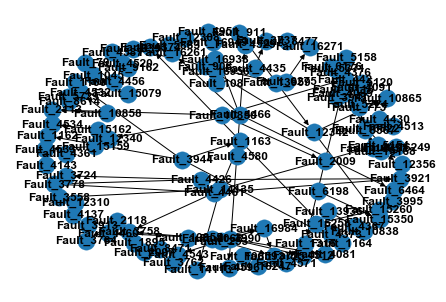

In [46]:
m2l_topology.parse_fault_relationships(graph_path,tmp_path,output_path)

# loop2gemodeller test 



In [47]:
save_faults=True
compute_etc=True

m2l_export.loop2geomodeller(test_data_path,tmp_path,output_path,'./dtm/dtm_rp.tif',bbox,save_faults,compute_etc)

In [48]:
os.chdir(test_data_path)
%system geomodellerbatch.exe -batch m2l.taskfile


['WARNING: An illegal reflective access operation has occurred',
 'WARNING: Illegal reflective access by com.dfa.util.Lib (file:/C:/GeoModeller/GeoModeller4.0.8_x64_88b64e610d9/bin/plugins/au.com.dfa.intrepid.lib_6.0.0.201911202221.jar) to field java.lang.ClassLoader.loadedLibraryNames',
 'WARNING: Please consider reporting this to the maintainers of com.dfa.util.Lib',
 'WARNING: Use --illegal-access=warn to enable warnings of further illegal reflective access operations',
 'WARNING: All illegal access operations will be denied in a future release',
 'COMPOSE EXTRA LENGTH FOR Mission_Group 0',
 'COMPOSE EXTRA LENGTH FOR Buldya_Group 0',
 'COMPOSE EXTRA LENGTH FOR Kunmarnara_Group 0',
 'COMPOSE EXTRA LENGTH FOR Mount_Palgrave_Group 0',
 'COMPOSE EXTRA LENGTH FOR Kaarnka_Group 0',
 'COMPOSE EXTRA LENGTH FOR Pussy_Cat_Group 0']

In [49]:
#%system geomodellerbatch.exe -batch m2l_compute.taskfile


In [50]:
import winsound
duration = 500  # milliseconds
freq = 1100  # Hz
winsound.Beep(freq, duration)
winsound.Beep(freq, duration)
duration=999
winsound.Beep(freq, duration)
